In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sibur-2-preprocessed/preprocessed_test.csv
/kaggle/input/sibur-2-preprocessed/preprocessed_train.csv
/kaggle/input/sibur20-naming-data/sample_submission.csv
/kaggle/input/sibur20-naming-data/train.csv
/kaggle/input/sibur20-naming-data/test.csv
/kaggle/input/sibur20-naming-data/baseline_submission.csv


In [21]:
!pip install strsimpy

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [22]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
!pip install cyrtranslit

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [24]:
!pip install pyod

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [25]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.damerau import Damerau
from strsimpy.optimal_string_alignment import OptimalStringAlignment
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.longest_common_subsequence import LongestCommonSubsequence
from strsimpy.metric_lcs import MetricLCS
from strsimpy.ngram import NGram
from strsimpy.qgram import QGram
from strsimpy import SIFT4
from catboost import CatBoostClassifier, Pool, cv
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import pycountry
import re
import cyrtranslit
from pyod.models.copod import COPOD
import networkx as nx

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [26]:
#random state
RS = 42
np.random.seed(RS)

In [27]:
train_full = pd.read_csv('/kaggle/input/sibur20-naming-data/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/sibur20-naming-data/test.csv', index_col=0)
train_full.shape, test.shape

((497819, 3), (213249, 2))

# word preprocessing

Привести к нижнему регистру, кириллицу в транслит, убрать все лишние символы.

In [28]:
train_full["name_1"] = train_full["name_1"].str.lower()
train_full["name_2"] = train_full["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [29]:
train_full["name_1"] = train_full["name_1"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))
train_full["name_2"] = train_full["name_2"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))

test["name_1"] = test["name_1"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))
test["name_2"] = test["name_2"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))

100%|██████████| 213249/213249 [00:01<00:00, 155641.13it/s]


In [30]:
train_full.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

# Validation scheme

In [31]:
#compare 4 chars from name_1 and name_2
srez = 4
train_full['4_str'] = train_full['name_1'].str[:srez]
#mask = train_full[train_full['name_1'].str[:srez] == train['name_2'].str[:srez]].copy()

#dict for unique values
dd = dict(zip(train_full['4_str'].unique(), np.arange(len(train_full['4_str'].unique()))))
train_full['4_str'] = train_full['4_str'].map(dd)
#for substr in train['4_str'].value_counts():
    

In [32]:
FOLDS = 5

# array of fold categories
cats = [[] for x in range(FOLDS)]
# array of fold lengths
fold_length = [0] * FOLDS

for x in train_full['4_str'].unique():
    # find fold with minimum length
    min_fold = np.argmin(fold_length)
    num_samples = train_full[train_full['4_str'] == x]['name_1'].count()
    
    cats[min_fold].append(x)
    fold_length[min_fold] += num_samples

print(f'Split complete! {FOLDS} folds in {fold_length} sizes.')

Split complete! 5 folds in [99564, 99564, 99564, 99564, 99563] sizes.


In [33]:
train_cats = cats[0] + cats[1] + cats[2] + cats[3]
val_cats = cats[4]

In [34]:
train = train_full[train_full['4_str'].isin(train_cats)]
valid = train_full[train_full['4_str'].isin(val_cats)]

In [35]:
train.shape, valid.shape

((398256, 4), (99563, 4))

In [36]:
train[train['is_duplicate'] == 1].shape, valid[valid['is_duplicate'] == 1].shape

((2878, 4), (780, 4))

### train graph

Сформировать граф из трейна, где нодами будут слова, а ребрами - связи между соседними словами. Затем удалить из трейна и теста ноды с числом ребер, больших чем порог.

In [37]:
G = nx.Graph()

def fill_graph(s):
    last_word = ''
    for i, word in enumerate(s.split()):
        G.add_node(word)
        if i > 0:
            G.add_edge(word, last_word)
        last_word = word
        
train['name_1'].progress_apply(lambda r: fill_graph(r))
train['name_2'].progress_apply(lambda r: fill_graph(r))

G.number_of_edges(), G.number_of_nodes()

100%|██████████| 398256/398256 [00:04<00:00, 83742.63it/s]


(32528, 16604)

### clear words with hight graph indexes

In [38]:
GRAPH_THRESHOLD = 50

def graph_index(s):
    counter = 0
    for word in s.split():
        try:
            counter += len(list(G.adj[word]))
        except KeyError:
            pass
    return counter

def graph_filter(s):
    result = ''
    for word in s.split():
        if graph_index(word) < GRAPH_THRESHOLD:
            result += word + ' '
    return result.rstrip()

In [39]:
train['name_1'] = train['name_1'].progress_apply(lambda r: graph_filter(r))
train['name_2'] = train['name_2'].progress_apply(lambda r: graph_filter(r))

valid['name_1'] = valid['name_1'].progress_apply(lambda r: graph_filter(r))
valid['name_2'] = valid['name_2'].progress_apply(lambda r: graph_filter(r))

test['name_1'] = test['name_1'].progress_apply(lambda r: graph_filter(r))
test['name_2'] = test['name_2'].progress_apply(lambda r: graph_filter(r))

100%|██████████| 398256/398256 [00:16<00:00, 23713.54it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 398256/398256 [00:18<00:00, 21019.72it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 99563/99563 [00:04<00:00, 22403.75it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: Sett

После удаления частых слов часть имен обратилась в ''. Оценим число, удалим их из трейна.

In [40]:
len(test[(test['name_1'] == '') | (test['name_2'] == '')])

11494

In [41]:
len(train[(train['name_1'] == '') | (train['name_2'] == '')])

20749

Число пострадавших "единичек" из трейна

In [42]:
train[((train['name_1'] == '') | (train['name_2'] == '')) &
      (train['is_duplicate'] == 1)]

,name_1,name_2,is_duplicate,4_str
pair_id,,,,
125170,italia,,1,290
287147,japan,,1,3115
427186,bst elastomers,,1,3400


In [43]:
train = train[(train['name_1'] != '') & (train['name_2'] != '')]
train.shape

(377507, 4)

# ---------------

In [44]:
#legal_entities = ['ООО', 'ОАО', 'ЗАО', 'ПАО', 'ОДО']

#for entity in tqdm(legal_entities):
#    train.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)
#    test.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)

In [45]:
#legal_entities = ["ltd\.", "co\.", "inc\.", "b\.v\.", "s\.c\.r\.l\.", "gmbh", "pvt\."]

#for entity in tqdm(legal_entities):
#    train.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)
#    test.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)

In [46]:
# ухудшает скор
#shit_words = ['sa', 's a', 'de', 'cv', 'gmb h', 'g mbh', 'llc', 's pa', 'sp a', 'spa', 'ag', 'rl', 's']

#for shit_word in tqdm(shit_words):
#    train.replace(re.compile('\s+{}'.format(shit_word)), "", inplace=True)
#    test.replace(re.compile(f"\s+{shit_word}\s*"), "", inplace=True)

In [47]:
#countries = [country.name.lower() for country in pycountry.countries]

#for country in tqdm(countries):
#    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
#    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

In [48]:
#print('Dropped', len(train[(train['name_1'] == '') | (train['name_2'] == '')]), 'samples.')

In [49]:
#train = train[(train['name_1'] != '') & (train['name_2'] != '')]

In [50]:
#train[train.is_duplicate==1].sample(15)

In [51]:
#train['name_1'].isna().sum(), train['name_2'].isna().sum(), test['name_1'].isna().sum(), test['name_2'].isna().sum()

# Feature generation

БОЛЬШЕ ФИЧЕЙ ДЛЯ БОГА ФИЧЕЙ!

In [52]:
levenshtein = Levenshtein()
train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
valid["levenstein"] = valid.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:11<00:00, 8395.76it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:24<00:00, 8662.44it/s] 


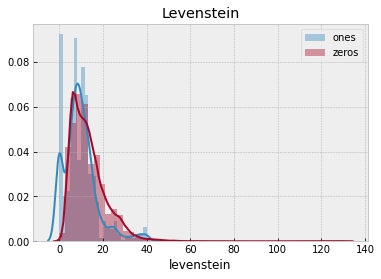

In [53]:
sns.distplot(valid[valid['is_duplicate'] == 1]['levenstein'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['levenstein'], label='zeros')
plt.title('Levenstein')
plt.legend();

In [54]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
valid["norm_levenstein"] = valid.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 99563/99563 [00:14<00:00, 7025.40it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:25<00:00, 8496.78it/s] 


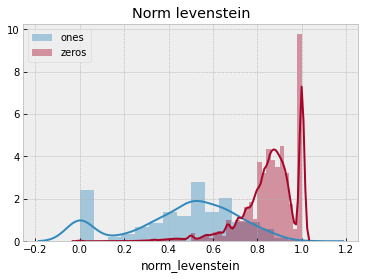

In [55]:
sns.distplot(valid[valid['is_duplicate'] == 1]['norm_levenstein'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['norm_levenstein'], label='zeros')
plt.title('Norm levenstein')
plt.legend();

In [56]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    try:
        res = float(len(c)) / (len(a) + len(b) - len(c))
    except ZeroDivisionError:
        res = 0
    return res

In [57]:
train["jaccard"] = train.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)
valid["jaccard"] = valid.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)
test["jaccard"] = test.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:03<00:00, 26656.85it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:06<00:00, 30661.08it/s]


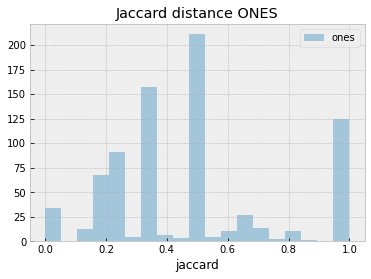

In [58]:
sns.distplot(valid[valid['is_duplicate'] == 1]['jaccard'], label='ones', kde=False)
plt.title('Jaccard distance ONES')
plt.legend();

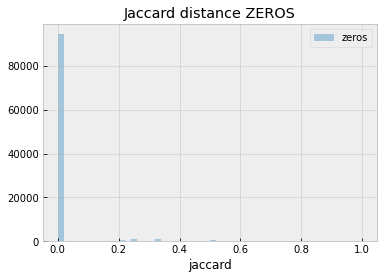

In [59]:
sns.distplot(valid[valid['is_duplicate'] == 0]['jaccard'], label='zeros', kde=False)
plt.title('Jaccard distance ZEROS')
plt.legend();

In [60]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,5))
def ngramm_distance(str_1, str_2):
    vectorizer.fit([str_1 + ' ' + str_2])
    return np.absolute(vectorizer.transform([str_1]) - vectorizer.transform([str_2])).sum()

In [61]:
train["ngramms"] = train.progress_apply(lambda r: ngramm_distance(r.name_1, r.name_2), axis=1)
valid["ngramms"] = valid.progress_apply(lambda r: ngramm_distance(r.name_1, r.name_2), axis=1)
test["ngramms"] = test.progress_apply(lambda r: ngramm_distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [02:31<00:00, 657.19it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [05:26<00:00, 652.59it/s]


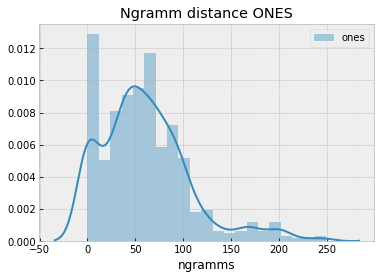

In [62]:
sns.distplot(valid[valid['is_duplicate'] == 1]['ngramms'], label='ones')
plt.title('Ngramm distance ONES')
plt.legend();

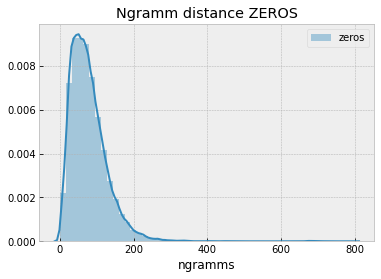

In [63]:
sns.distplot(valid[valid['is_duplicate'] == 0]['ngramms'], label='zeros')
plt.title('Ngramm distance ZEROS')
plt.legend();

In [64]:
def calc_1_in_2(str_1, str_2):
    if str_1 == '':
        return 0
    word = str_1.split()[0]
    return int(word in str_2)

In [65]:
train["1_in_2"] = train.progress_apply(lambda r: calc_1_in_2(r.name_1, r.name_2), axis=1)
valid["1_in_2"] = valid.progress_apply(lambda r: calc_1_in_2(r.name_1, r.name_2), axis=1)
test["1_in_2"] = test.progress_apply(lambda r: calc_1_in_2(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 34947.65it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:06<00:00, 33392.24it/s]


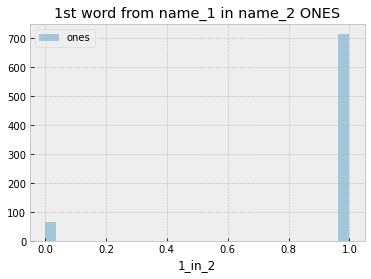

In [66]:
sns.distplot(valid[valid['is_duplicate'] == 1]['1_in_2'], label='ones', kde=False)
plt.title('1st word from name_1 in name_2 ONES')
plt.legend();

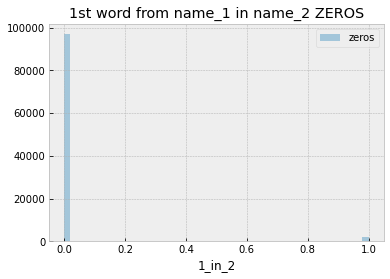

In [67]:
sns.distplot(valid[valid['is_duplicate'] == 0]['1_in_2'], label='zeros', kde=False)
plt.title('1st word from name_1 in name_2 ZEROS')
plt.legend();

In [68]:
train["2_in_1"] = train.progress_apply(lambda r: calc_1_in_2(r.name_2, r.name_1), axis=1)
valid["2_in_1"] = valid.progress_apply(lambda r: calc_1_in_2(r.name_2, r.name_1), axis=1)
test["2_in_1"] = test.progress_apply(lambda r: calc_1_in_2(r.name_2, r.name_1), axis=1)

100%|██████████| 99563/99563 [00:03<00:00, 31982.45it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:06<00:00, 33740.63it/s]


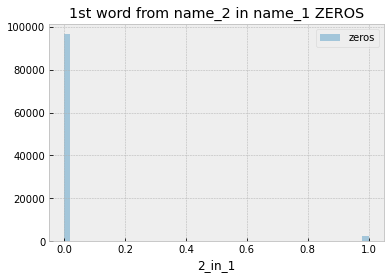

In [69]:
sns.distplot(valid[valid['is_duplicate'] == 0]['2_in_1'], label='zeros', kde=False)
plt.title('1st word from name_2 in name_1 ZEROS')
plt.legend();

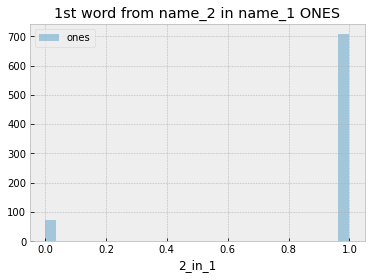

In [70]:
sns.distplot(valid[valid['is_duplicate'] == 1]['2_in_1'], label='ones', kde=False)
plt.title('1st word from name_2 in name_1 ONES')
plt.legend();

In [71]:
train['name_1_joined'] = train['name_1'].str.replace(' ', '')
train['name_2_joined'] = train['name_2'].str.replace(' ', '')

valid['name_1_joined'] = valid['name_1'].str.replace(' ', '')
valid['name_2_joined'] = valid['name_2'].str.replace(' ', '')

test['name_1_joined'] = test['name_1'].str.replace(' ', '')
test['name_2_joined'] = test['name_2'].str.replace(' ', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [72]:
train["jaccard_joined"] = train.progress_apply(lambda r: get_jaccard_sim(r.name_1_joined, r.name_2_joined), axis=1)
valid["jaccard_joined"] = valid.progress_apply(lambda r: get_jaccard_sim(r.name_1_joined, r.name_2_joined), axis=1)
test["jaccard_joined"] = test.progress_apply(lambda r: get_jaccard_sim(r.name_1_joined, r.name_2_joined), axis=1)

100%|██████████| 99563/99563 [00:03<00:00, 31549.06it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:06<00:00, 32262.79it/s]


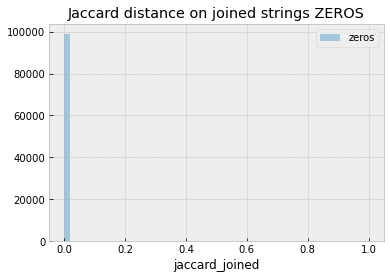

In [73]:
sns.distplot(valid[valid['is_duplicate'] == 0]['jaccard_joined'], label='zeros', kde=False)
plt.title('Jaccard distance on joined strings ZEROS')
plt.legend();

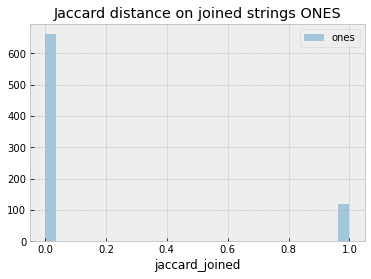

In [74]:
sns.distplot(valid[valid['is_duplicate'] == 1]['jaccard_joined'], label='ones', kde=False)
plt.title('Jaccard distance on joined strings ONES')
plt.legend();

In [75]:
levenshtein = Levenshtein()
train["levenstein_joined"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                  axis=1)
valid["levenstein_joined"] = valid.progress_apply(lambda r: levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                  axis=1)
test["levenstein_joined"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                axis=1)

100%|██████████| 99563/99563 [00:10<00:00, 9608.85it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 213249/213249 [00:24<00:00, 8855.79it/s] 


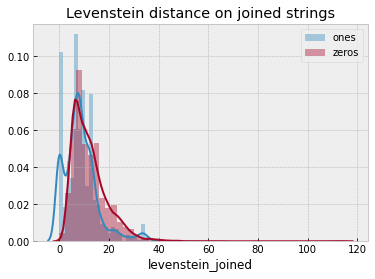

In [76]:
sns.distplot(valid[valid['is_duplicate'] == 1]['levenstein_joined'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['levenstein_joined'], label='zeros')
plt.title('Levenstein distance on joined strings')
plt.legend();

In [77]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein_joined"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                axis=1)
valid["norm_levenstein_joined"] = valid.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                axis=1)
test["norm_levenstein_joined"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                              axis=1)

100%|██████████| 99563/99563 [00:10<00:00, 9937.10it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:23<00:00, 9234.07it/s] 


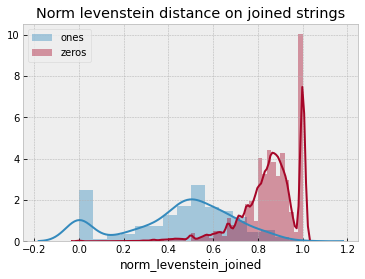

In [78]:
sns.distplot(valid[valid['is_duplicate'] == 1]['norm_levenstein_joined'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['norm_levenstein_joined'], label='zeros')
plt.title('Norm levenstein distance on joined strings')
plt.legend();

In [79]:
train["num_chars"] = train.progress_apply(lambda r: np.absolute(len(r.name_1_joined) - len(r.name_2_joined)),
                                          axis=1)
valid["num_chars"] = valid.progress_apply(lambda r: np.absolute(len(r.name_1_joined) - len(r.name_2_joined)),
                                          axis=1)
test["num_chars"] = test.progress_apply(lambda r: np.absolute(len(r.name_1_joined) - len(r.name_2_joined)),
                                        axis=1)

100%|██████████| 99563/99563 [00:03<00:00, 32868.75it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 213249/213249 [00:08<00:00, 25531.74it/s]


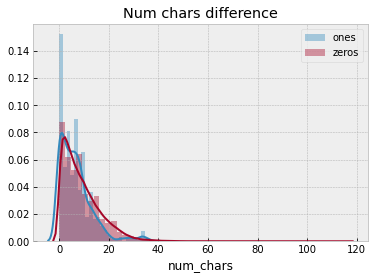

In [80]:
sns.distplot(valid[valid['is_duplicate'] == 1]['num_chars'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['num_chars'], label='zeros')
plt.title('Num chars difference')
plt.legend();

In [81]:
train["num_words"] = train.progress_apply(lambda r: np.absolute(len(r.name_1_joined.split()) - len(r.name_2_joined.split())),
                                          axis=1)
valid["num_words"] = valid.progress_apply(lambda r: np.absolute(len(r.name_1_joined.split()) - len(r.name_2_joined.split())),
                                          axis=1)
test["num_words"] = test.progress_apply(lambda r: np.absolute(len(r.name_1_joined.split()) - len(r.name_2_joined.split())),
                                        axis=1)

100%|██████████| 99563/99563 [00:03<00:00, 31549.25it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 213249/213249 [00:07<00:00, 28479.57it/s]


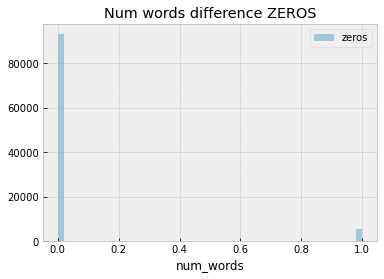

In [82]:
sns.distplot(valid[valid['is_duplicate'] == 0]['num_words'], label='zeros', kde=False)
plt.title('Num words difference ZEROS')
plt.legend();

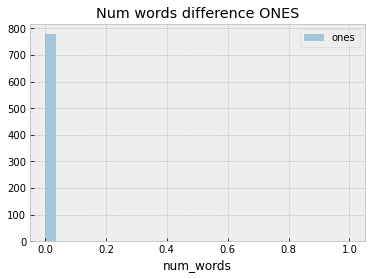

In [83]:
sns.distplot(valid[valid['is_duplicate'] == 1]['num_words'], label='ones', kde=False)
plt.title('Num words difference ONES')
plt.legend();

In [84]:
def _subseq_count(str_1, str_2):
    counter = 0
    subs = []
    str = ''
    for char in str_1:
        str += char
        subs.append(str)
    for s in subs:
        if s in str_2:
            counter += len(s)
    return counter

def subseq_count(str_1, str_2):
    count = 0
    for i, s in enumerate(str_1):
        count += _subseq_count(str_1[i:], str_2)
    return count

In [85]:
train["subseq_rate"] = train.progress_apply(lambda r: _subseq_count(r.name_1_joined, r.name_2_joined) +
                                            _subseq_count(r.name_2_joined, r.name_1_joined), axis=1)
valid["subseq_rate"] = valid.progress_apply(lambda r: _subseq_count(r.name_1_joined, r.name_2_joined) +
                                            _subseq_count(r.name_2_joined, r.name_1_joined), axis=1)
test["subseq_rate"] = test.progress_apply(lambda r: _subseq_count(r.name_1_joined, r.name_2_joined) +
                                          _subseq_count(r.name_2_joined, r.name_1_joined), axis=1)

100%|██████████| 99563/99563 [00:06<00:00, 14639.81it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 213249/213249 [00:14<00:00, 14475.40it/s]


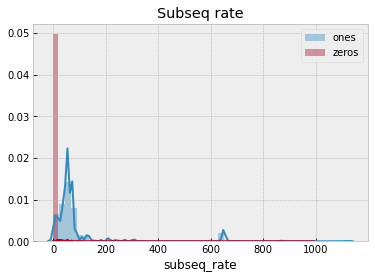

In [86]:
sns.distplot(valid[valid['is_duplicate'] == 1]['subseq_rate'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['subseq_rate'], label='zeros')
plt.title('Subseq rate')
plt.legend();

In [87]:
def word_compare(str_1, str_2):
    count = 0
    words = str_1.split()
    for word in words:
        if word in str_2:
            count += 1
    return count

In [88]:
train["word_compare"] = train.progress_apply(lambda r: word_compare(r.name_1, r.name_2), axis=1)
valid["word_compare"] = valid.progress_apply(lambda r: word_compare(r.name_1, r.name_2), axis=1)
test["word_compare"] = test.progress_apply(lambda r: word_compare(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:03<00:00, 27834.49it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:07<00:00, 27836.25it/s]


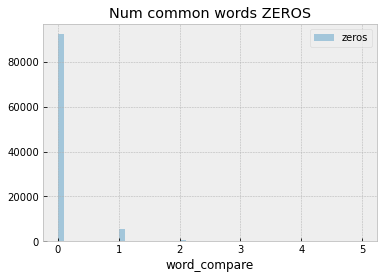

In [89]:
sns.distplot(valid[valid['is_duplicate'] == 0]['word_compare'], label='zeros', kde=False)
plt.title('Num common words ZEROS')
plt.legend();

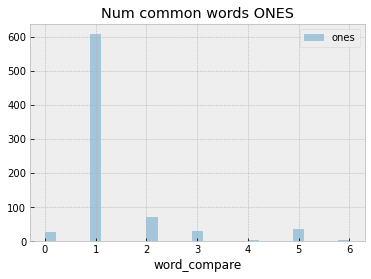

In [90]:
sns.distplot(valid[valid['is_duplicate'] == 1]['word_compare'], label='ones', kde=False)
plt.title('Num common words ONES')
plt.legend();

### word indexes

In [91]:
train["sum_word_index"] = train.progress_apply(lambda r: graph_index(r.name_1 + ' ' + r.name_2), axis=1)
valid["sum_word_index"] = valid.progress_apply(lambda r: graph_index(r.name_1 + ' ' + r.name_2), axis=1)
test["sum_word_index"] = test.progress_apply(lambda r: graph_index(r.name_1 + ' ' + r.name_2), axis=1)

100%|██████████| 99563/99563 [00:04<00:00, 22799.85it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:12<00:00, 17272.20it/s]


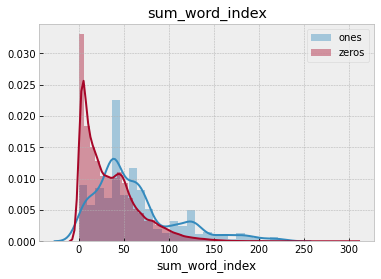

In [92]:
sns.distplot(valid[valid['is_duplicate'] == 1]['sum_word_index'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['sum_word_index'], label='zeros')
plt.title('sum_word_index')
plt.legend();

### Demarou

In [93]:
damerau = Damerau()
train["damerau"] = train.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)
valid["damerau"] = valid.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)
test["damerau"] = test.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:22<00:00, 4415.76it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:52<00:00, 4024.52it/s]


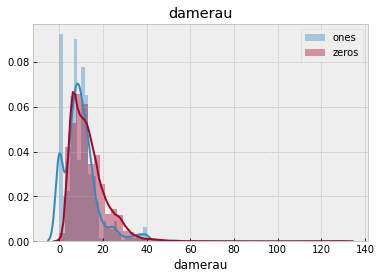

In [94]:
sns.distplot(valid[valid['is_duplicate'] == 1]['damerau'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['damerau'], label='zeros')
plt.title('damerau')
plt.legend();

### Optimal String Alignment

In [95]:
optimal_string_alignment = OptimalStringAlignment()
train["optimal_string_alignment"] = train.progress_apply(lambda r: optimal_string_alignment.distance(r.name_1, r.name_2),
                                                         axis=1)
valid["optimal_string_alignment"] = valid.progress_apply(lambda r: optimal_string_alignment.distance(r.name_1, r.name_2),
                                                         axis=1)
test["optimal_string_alignment"] = test.progress_apply(lambda r: optimal_string_alignment.distance(r.name_1, r.name_2),
                                                       axis=1)

100%|██████████| 99563/99563 [00:18<00:00, 5478.21it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 213249/213249 [00:36<00:00, 5778.30it/s]


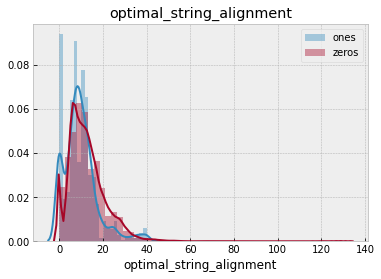

In [96]:
sns.distplot(valid[valid['is_duplicate'] == 1]['optimal_string_alignment'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['optimal_string_alignment'], label='zeros')
plt.title('optimal_string_alignment')
plt.legend();

### Jaro-Winkler

In [97]:
jarowinkler = JaroWinkler()
train["jarowinkler"] = train.progress_apply(lambda r: jarowinkler.similarity(r.name_1, r.name_2), axis=1)
valid["jarowinkler"] = valid.progress_apply(lambda r: jarowinkler.similarity(r.name_1, r.name_2), axis=1)
test["jarowinkler"] = test.progress_apply(lambda r: jarowinkler.similarity(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:05<00:00, 18206.49it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:11<00:00, 18377.56it/s]


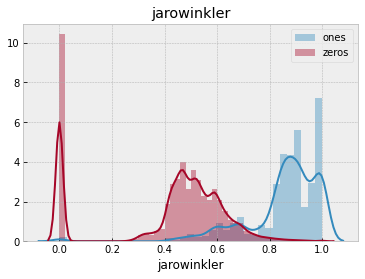

In [98]:
sns.distplot(valid[valid['is_duplicate'] == 1]['jarowinkler'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['jarowinkler'], label='zeros')
plt.title('jarowinkler')
plt.legend();

### Longest Common Subsequence

In [99]:
lcs = LongestCommonSubsequence()
train["lcs_length"] = train.progress_apply(lambda r: lcs.length(r.name_1, r.name_2), axis=1)
valid["lcs_length"] = valid.progress_apply(lambda r: lcs.length(r.name_1, r.name_2), axis=1)
test["lcs_length"] = test.progress_apply(lambda r: lcs.length(r.name_1, r.name_2), axis=1)
train["lcs_distance"] = train.progress_apply(lambda r: lcs.distance(r.name_1, r.name_2), axis=1)
valid["lcs_distance"] = valid.progress_apply(lambda r: lcs.distance(r.name_1, r.name_2), axis=1)
test["lcs_distance"] = test.progress_apply(lambda r: lcs.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:13<00:00, 7144.97it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 99563/99563 [00:14<00:00, 6856.16it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:24<00:00, 8800.84it/s] 


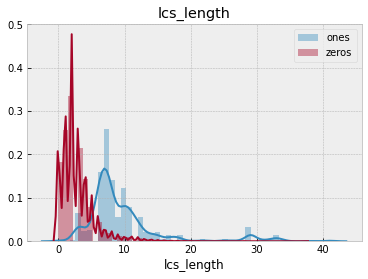

In [100]:
sns.distplot(valid[valid['is_duplicate'] == 1]['lcs_length'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['lcs_length'], label='zeros')
plt.title('lcs_length')
plt.legend();

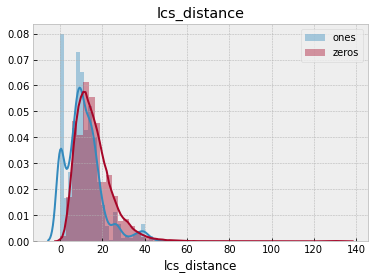

In [101]:
sns.distplot(valid[valid['is_duplicate'] == 1]['lcs_distance'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['lcs_distance'], label='zeros')
plt.title('lcs_distance')
plt.legend();

### MetricLCS

In [102]:
metric_lcs = MetricLCS()
train["metric_lcs"] = train.progress_apply(lambda r: metric_lcs.distance(r.name_1, r.name_2), axis=1)
valid["metric_lcs"] = valid.progress_apply(lambda r: metric_lcs.distance(r.name_1, r.name_2), axis=1)
test["metric_lcs"] = test.progress_apply(lambda r: metric_lcs.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:13<00:00, 7622.57it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:28<00:00, 7437.51it/s] 


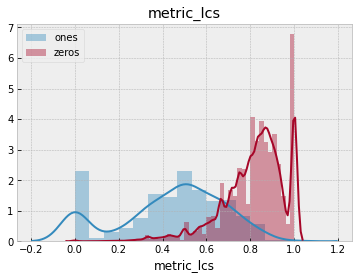

In [103]:
sns.distplot(valid[valid['is_duplicate'] == 1]['metric_lcs'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['metric_lcs'], label='zeros')
plt.title('metric_lcs')
plt.legend();

### twogram

In [104]:
twogram = NGram(2)
train["twogram"] = train.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)
valid["twogram"] = valid.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)
test["twogram"] = test.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:25<00:00, 3879.22it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:49<00:00, 4275.81it/s]


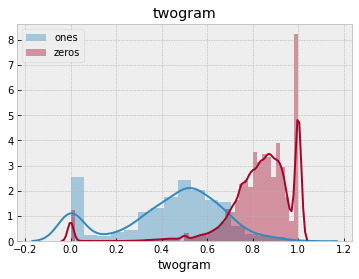

In [105]:
sns.distplot(valid[valid['is_duplicate'] == 1]['twogram'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['twogram'], label='zeros')
plt.title('twogram')
plt.legend();

### Qgram

In [106]:
qgram = QGram(2)
train["qgram"] = train.progress_apply(lambda r: qgram.distance(r.name_1, r.name_2), axis=1)
valid["qgram"] = valid.progress_apply(lambda r: qgram.distance(r.name_1, r.name_2), axis=1)
test["qgram"] = test.progress_apply(lambda r: qgram.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:07<00:00, 14175.98it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:17<00:00, 12299.14it/s]


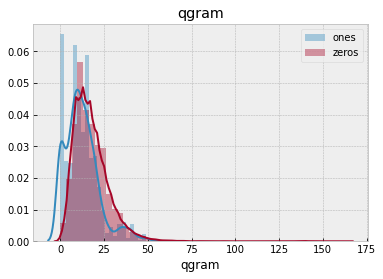

In [107]:
sns.distplot(valid[valid['is_duplicate'] == 1]['qgram'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['qgram'], label='zeros')
plt.title('qgram')
plt.legend();

### SIFT4

In [108]:
sift = SIFT4()
train["sift"] = train.progress_apply(lambda r: sift.distance(r.name_1, r.name_2), axis=1)
valid["sift"] = valid.progress_apply(lambda r: sift.distance(r.name_1, r.name_2), axis=1)
test["sift"] = test.progress_apply(lambda r: sift.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:08<00:00, 11880.68it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:23<00:00, 8924.14it/s]


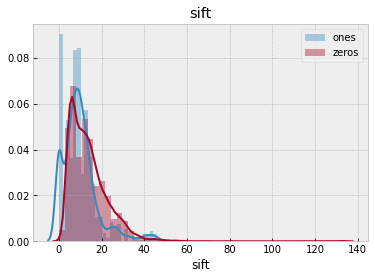

In [109]:
sns.distplot(valid[valid['is_duplicate'] == 1]['sift'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['sift'], label='zeros')
plt.title('sift')
plt.legend();

# Pseudo-labeling

In [122]:
def vectorize(X_train, X_valid, X_test, vectorizer):
   
    vectorizer.fit(X_train[:, 0] + ' ' + X_train[:, 1])
    X_train_ngramms = np.absolute(vectorizer.transform(X_train[:, 0]) - vectorizer.transform(X_train[:, 1]))
    X_valid_ngramms = np.absolute(vectorizer.transform(X_valid[:, 0]) - vectorizer.transform(X_valid[:, 1]))
    X_test_ngramms = np.absolute(vectorizer.transform(X_test[:, 0]) - vectorizer.transform(X_test[:, 1]))
    
    return X_train_ngramms, X_valid_ngramms, X_test_ngramms

    
def scale(X_train, X_valid, X_test, scaler):
    X_train_scaled = scaler.fit_transform(X_train).astype(np.float)
    X_valid_scaled = scaler.transform(X_valid).astype(np.float)
    X_test_scaled = scaler.transform(X_test).astype(np.float)
    
    return X_train_scaled, X_valid_scaled, X_test_scaled

In [111]:
exclude_columns = ['name_1', 'name_2', 'name_1_joined', 'name_2_joined', '4_str']
columns = train.drop(exclude_columns + ['is_duplicate'], axis=1).columns
columns_names = ['name_1', 'name_2']

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,5), max_features=5000)
scaler = StandardScaler()

columns

Index(['levenstein', 'norm_levenstein', 'jaccard', 'ngramms', '1_in_2',
       '2_in_1', 'jaccard_joined', 'levenstein_joined',
       'norm_levenstein_joined', 'num_chars', 'num_words', 'subseq_rate',
       'word_compare', 'sum_word_index', 'damerau', 'optimal_string_alignment',
       'jarowinkler', 'lcs_length', 'lcs_distance', 'metric_lcs', 'twogram',
       'qgram', 'sift'],
      dtype='object')

### linear regression

In [123]:
X_train = train[columns_names].values
X_valid = valid[columns_names].values
X_test = test[columns_names].values
y_train = train['is_duplicate'].values

X_train, X_valid, X_test = vectorize(X_train, X_valid, X_test, vectorizer)

# Регрессия - только на н-граммах, остальные фичи не добавляем
lr = LogisticRegression(random_state=RS, verbose=True, class_weight='balanced', C=0.01,
                        n_jobs=-1).fit(X_train, y_train)

train['lr_labels'] = lr.predict_proba(X_train)[:, 1]
valid['lr_labels'] = lr.predict_proba(X_valid)[:, 1]
test['lr_labels'] = lr.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.6s finished
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


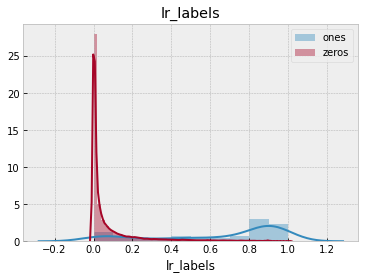

In [124]:
sns.distplot(valid[valid['is_duplicate'] == 1]['lr_labels'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['lr_labels'], label='zeros')
plt.title('lr_labels')
plt.legend();

### kmeans

In [125]:
clustering = KMeans(n_clusters=20, random_state=RS).fit(X_train)
train['kmeans_labels'] = clustering.predict(X_train)
valid['kmeans_labels'] = clustering.predict(X_valid)
test['kmeans_labels'] = clustering.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


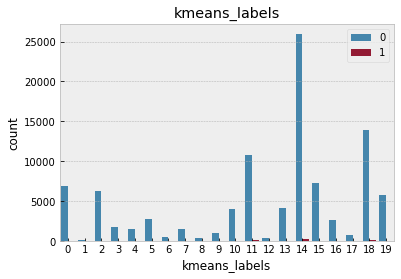

In [126]:
sns.countplot(data=valid, x='kmeans_labels', hue='is_duplicate')
plt.title('kmeans_labels')
plt.legend();

In [127]:
enc = OneHotEncoder(drop='first')
OHE_train = enc.fit_transform(train['kmeans_labels'].values.reshape(-1, 1))
OHE_valid = enc.transform(valid['kmeans_labels'].values.reshape(-1, 1))
OHE_test = enc.transform(test['kmeans_labels'].values.reshape(-1, 1))

train = train.drop('kmeans_labels', axis=1)
valid = valid.drop('kmeans_labels', axis=1)
test = test.drop('kmeans_labels', axis=1)

train = pd.concat([train, pd.DataFrame(OHE_train.toarray(), index=train.index)], axis=1)
valid = pd.concat([valid, pd.DataFrame(OHE_valid.toarray(), index=valid.index)], axis=1)
test = pd.concat([test, pd.DataFrame(OHE_test.toarray(), index=test.index)], axis=1)

### COPOD

In [128]:
X_train = train[columns].values
X_valid = valid[columns].values
X_test = test[columns].values
y_train = train['is_duplicate'].values

X_train, X_valid, X_test = scale(X_train, X_valid, X_test, scaler)

clf = COPOD()
clf.fit(X_train)

train['COPOD'] = clf.predict(X_train)
valid['COPOD'] = clf.predict(X_valid)
test['COPOD'] = clf.predict(X_test)

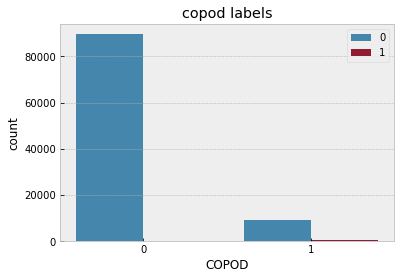

In [129]:
sns.countplot(data=valid, x='COPOD', hue='is_duplicate')
plt.title('copod labels')
plt.legend();

# Catboost

In [130]:
exclude_columns = ['name_1', 'name_2', 'name_1_joined', 'name_2_joined', '4_str']
columns = train.drop(exclude_columns + ['is_duplicate'], axis=1).columns

In [131]:
X_train = train[columns].values
y_train = train['is_duplicate'].values
train_data = Pool(X_train, y_train)
X_train.shape, y_train.shape

((377507, 44), (377507,))

In [133]:
X_valid = valid[columns].values
y_valid = valid['is_duplicate'].values
valid_data = Pool(X_valid, y_valid)
X_valid.shape, y_valid.shape

((99563, 44), (99563,))

In [134]:
X_test = test[columns].values
X_test.shape

(213249, 44)

In [135]:
params = {"iterations": 1000,
          "depth": 2,
          "loss_function": "CrossEntropy",
          "verbose": False,
          "eval_metric": "F1",
          "random_seed": RS,
          "learning_rate": 0.8,
#          "auto_class_weights": 'Balanced',
          "use_best_model": True,
          "l2_leaf_reg": 100
          }

model = CatBoostClassifier(**params)
model.fit(train_data, plot=True, eval_set=valid_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [136]:
pd.DataFrame(model.get_feature_importance(), index=columns).sort_values(by=0, ascending=False).head()

,0
jaccard,32.381980
lr_labels,30.579239
lcs_length,8.321830
sum_word_index,8.267970
subseq_rate,6.562015


In [137]:
preds = model.predict(X_valid)
f1_score(y_valid, preds)

0.5940752602081665

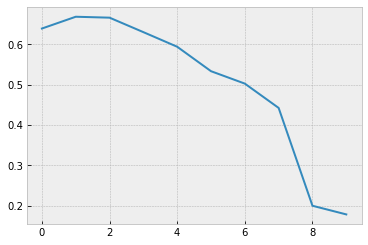

In [138]:
preds = model.predict_proba(X_valid)[:, 1]
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92]
metrics = []
for thr in thresholds:
    labels = (preds > thr).astype(int)
    #print('-' * 10, 'THRESHOLD =', thr, '-' * 10)
    #print(classification_report(y_valid, labels))
    #print()
    metric = f1_score(y_valid, labels)
    metrics.append(metric)
plt.plot(metrics)

In [ ]:
#X_train = train[columns].values
#y_train = train['is_duplicate'].values
#train_data = Pool(X_train, y_train)

In [ ]:
#params['use_best_model'] = False
#params['iterations'] = 200
#model = CatBoostClassifier(**params)
#model.fit(train_data, plot=True)

In [139]:
def submit(preds, threshold=0.5, filename='submit.csv', dataset=test):
    labels = (preds > threshold).astype(int)
    result = pd.DataFrame({'pair_id': dataset.index,
                           'is_duplicate': labels})
    print(f'Число положительных классов для threshold={threshold}: {result["is_duplicate"].sum()} / {result["is_duplicate"].mean():.2%}')
    result.to_csv(filename, index=False)
    print('Done!')
    return result

In [140]:
preds = model.predict_proba(X_test)[:, 1]
results = []
for thr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    filename = f'submit_{thr}.csv'
    res = submit(preds, threshold=thr, filename=filename, dataset=test)
    results.append(res)

Число положительных классов для threshold=0.1: 1199 / 0.56%
Done!
Число положительных классов для threshold=0.2: 995 / 0.47%
Done!
Число положительных классов для threshold=0.3: 851 / 0.40%
Done!
Число положительных классов для threshold=0.4: 760 / 0.36%
Done!
Число положительных классов для threshold=0.5: 679 / 0.32%
Done!
Число положительных классов для threshold=0.6: 604 / 0.28%
Done!
Число положительных классов для threshold=0.7: 521 / 0.24%
Done!
Число положительных классов для threshold=0.8: 430 / 0.20%
Done!
Число положительных классов для threshold=0.9: 151 / 0.07%
Done!


# Ручная валидация

In [143]:
idx = results[0][results[0]['is_duplicate'] == 1].index
test.loc[idx, ['name_1', 'name_2']].sample(25)

,name_1,name_2
55086,direct leisure golf distributors,pl
123952,hee,lg chem
38024,cbc,guanghaida rubberplastic
154386,comercializadora giraldo z,comercializadora
193113,sonica,haemotronic rl cv
138082,borouge,hs
8916,tag,toyota motor indonesia
43850,,gac marines
194645,h o,soft walk
89160,industrias madetex,reda pakistan
